## Download and Format Images 

Decide below which "concepts" to include. These are the classes you want to be able to identify.

In [1]:
# Missing Mollusca & Nemertea

concepts_to_include = [
    'Annelida',
    'Ascidiacea',
    'Asteroidea',
    'Ceriantharia',
    'Crinoidea',
    'Echinoidea',
    'Hexacorallia',
    'Holothuroidea',
    'Octocorallia',
    'Ophiuroidea',
    'Porifera',
    'Pycnogonida',
]

Using fathomnet's api we can look and see the number of bounding boxes present in fathomnet for each species

In [2]:
!pip install fathomnet -q

count_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --count'
#!{count_command}

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


Some of these are too low to use in our training, so for those less than 100 bounding boxes we will remove them from the included list

In [3]:
too_few_bboxes = ['Annelida','Ascidiacea', 'Echinoidea', 'Pycnogonida']

concepts_to_include = [concept for concept in concepts_to_include if concept not in too_few_bboxes]
concepts_to_include

['Asteroidea',
 'Ceriantharia',
 'Crinoidea',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera']

Now, we can actually download the images from fathomnet

In [4]:
# Download the images from the fathomnet database
import os

data_directory = os.path.join('datasets', 'sea_data')
img_dir = os.path.join(data_directory, 'images')
label_dir = os.path.join(data_directory, 'labels')

count_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --format voc --img-download "{img_dir}" --output "{label_dir}"'
#!{count_command}

Let's take a look at a sample of these images and with their bounding boxes

In [5]:
import xml.etree.ElementTree as ET

def parseXml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_pair = []

    for obj in root.findall('object'):
        name_key = obj.find('name').text
    
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        bbox_pair.append((name_key, (xmin, ymin, xmax, ymax)))
    
    return bbox_pair

In [6]:
!pip install opencv -q

import cv2
from IPython.display import Image, display

def draw_boxes(image, bboxes):    
    for label, (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


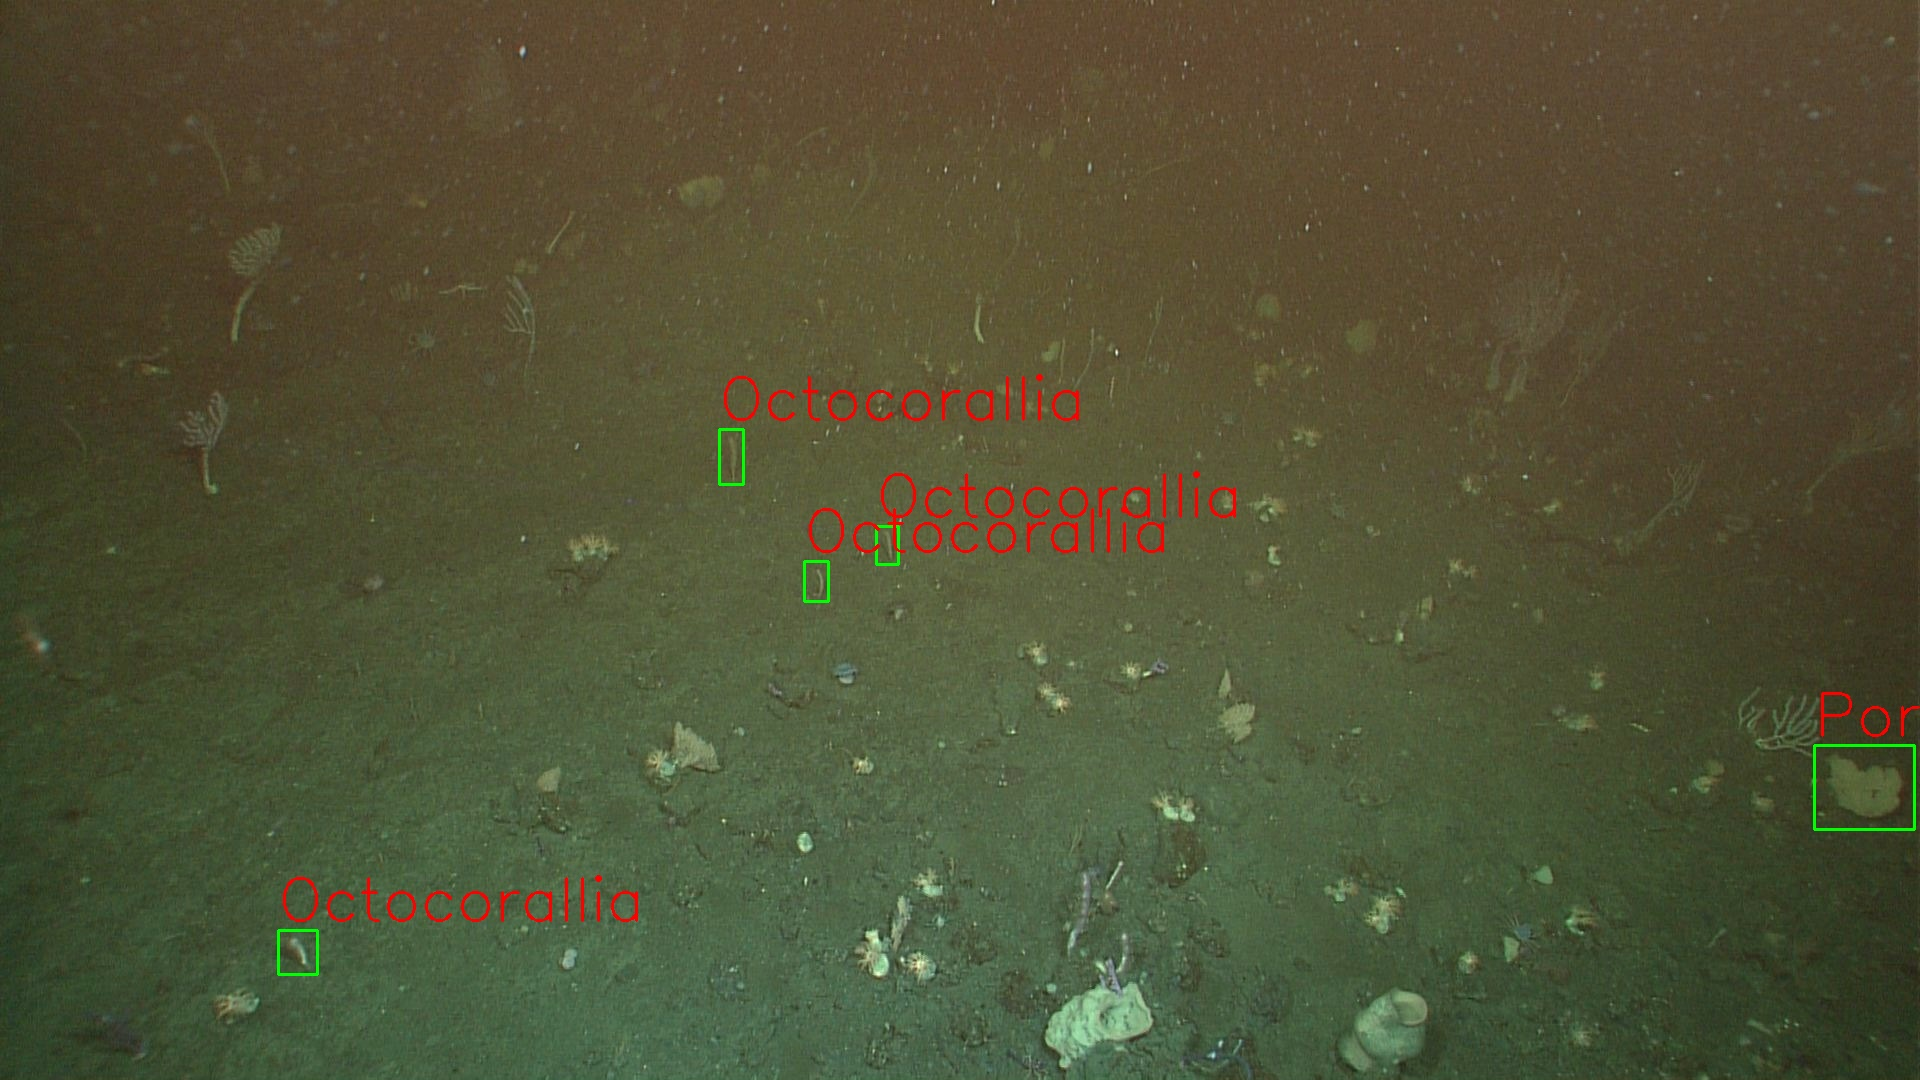

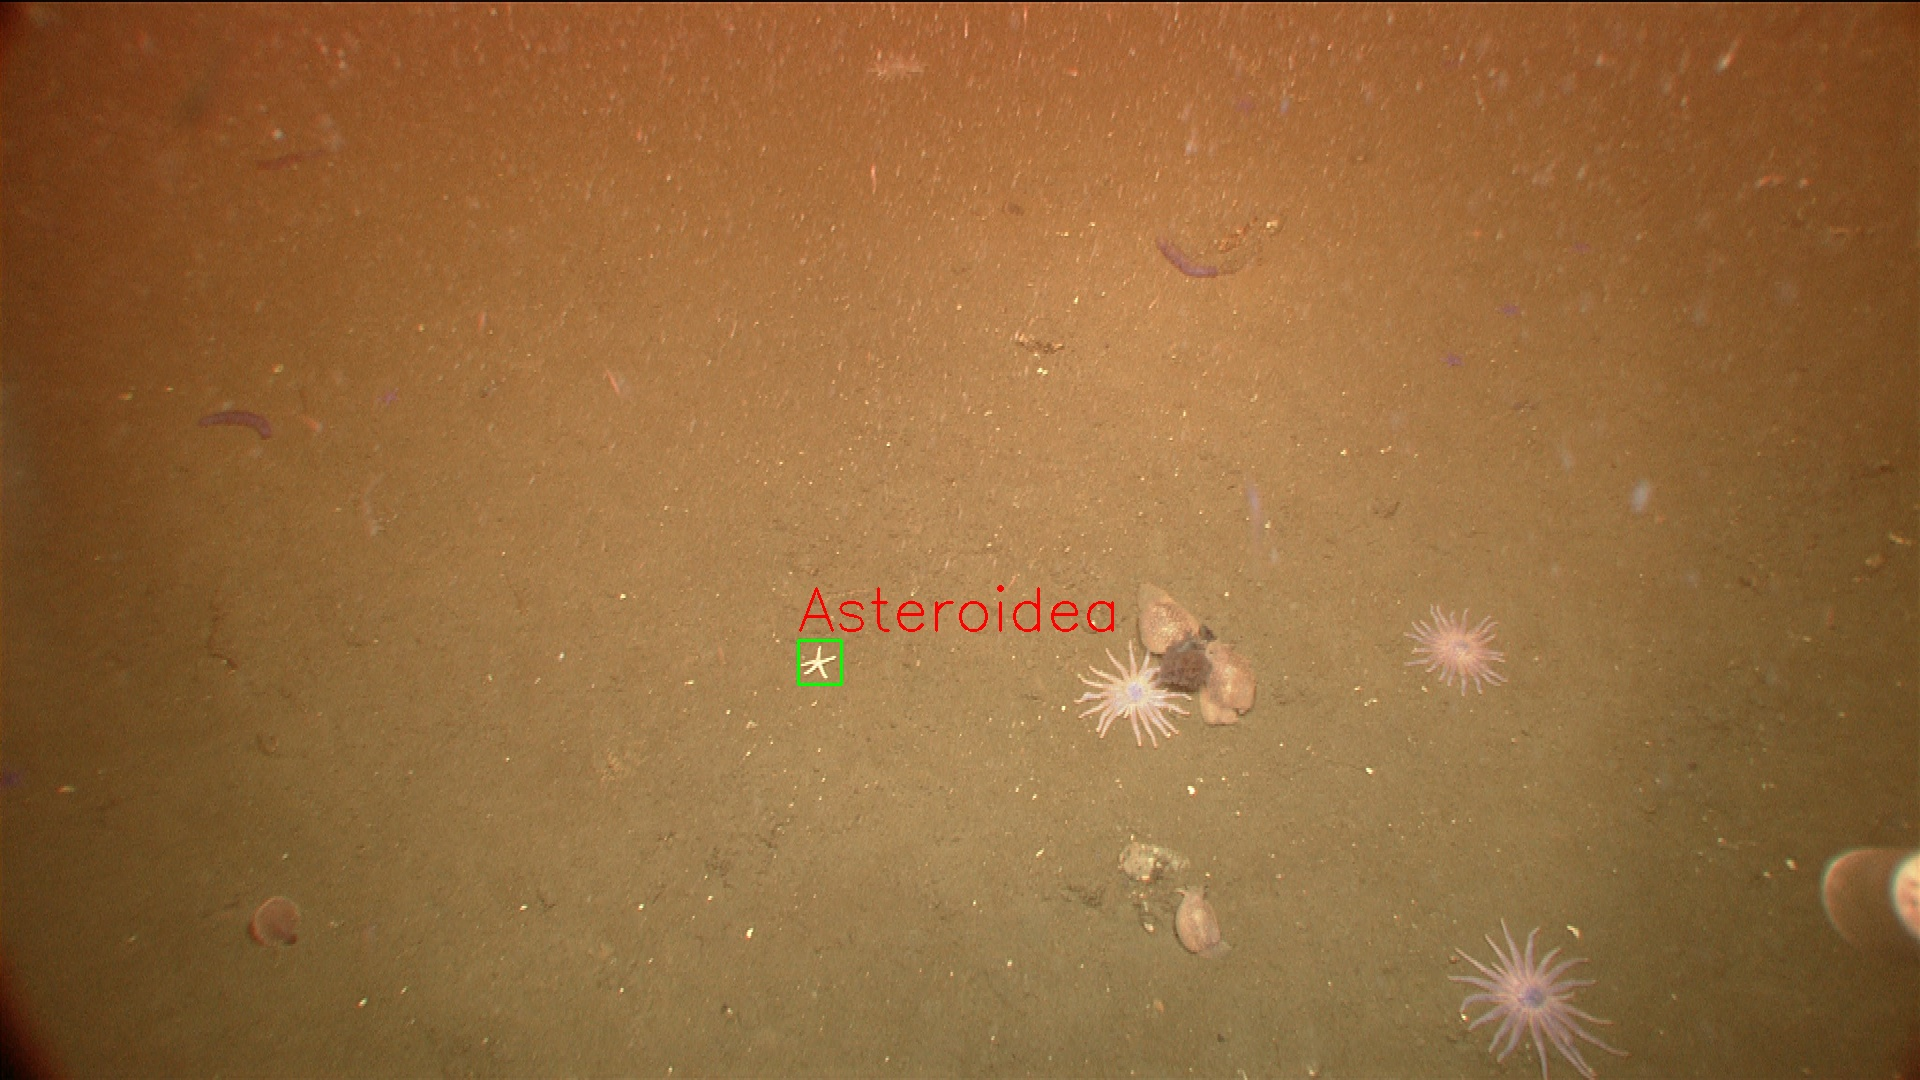

In [7]:
!pip install numpy -q

import numpy as np

number_to_choose = 2
random_seed = 80
np.random.seed(random_seed)

image_dir = os.path.join(data_directory, 'images')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]


random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, _ = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parseXml(os.path.join(data_directory, 'labels', f"{uid}.xml"))
    
    draw_boxes(image, bboxes)

## Break into train-val-test split

For this experiment we are going to use a train-val-test split of 70%-20%-10%

Since images are encoded using uuid4 we know that there is no order to the downloaded images this means that we can just move the first 70% of each concept into a training directory and so on.
We want to do this by concept so that we ensure that each concept is well represented in our training set.

### Split into concepts

In [8]:
label_directory = os.path.join(data_directory, 'labels')

concept_names = {}
for filename in os.listdir(label_directory):
    if not filename.endswith('.xml'): continue
        
    xml_file_path = os.path.join(label_directory, filename)
    root_name, _ = os.path.splitext(filename)

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    for obj in root.findall('.//object'):
        name = obj.find('name').text
        if name not in concept_names:
            concept_names[name] = set()
        
        concept_names[name].add(root_name)
            
for concept, names in concept_names.items():
    print(f'Concept: {concept} ::: {len(names)}')


Concept: Porifera ::: 2725
Concept: Holothuroidea ::: 821
Concept: Asteroidea ::: 2667
Concept: Hexacorallia ::: 82
Concept: Ophiuroidea ::: 2687
Concept: Crinoidea ::: 1229
Concept: Ceriantharia ::: 544
Concept: Octocorallia ::: 135


### Move Images for training

In [9]:
!pip install pyyaml
import yaml

train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

def createYamlFile(yaml_name='data'):
    data = {
        "path": 'sea_data',
        "train": [os.path.join('images', train_dir)],
        "val": [os.path.join('images', val_dir)],
        "test": [os.path.join('images', test_dir)],
        "names": {str(idx): class_name for idx, class_name in enumerate(concepts_to_include)}
    }

    with open(os.path.join(data_directory, f"{yaml_name}.yaml"), "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

createYamlFile()

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import shutil

def copyImageToLocation(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'images')
    src_file = os.path.join(curr_location, f"{uid}.png")

    file_exists = os.path.isfile(os.path.join(curr_location, f"{uid}.png"))
    if not file_exists: return

    os.makedirs(os.path.join(curr_location, dest_dir), exist_ok=True)
    dest_file = os.path.join(curr_location, dest_dir, f"{new_id}.png")

    shutil.copy(src_file, dest_file)

In [11]:
import xml.etree.ElementTree as ET
import cv2

def createTxtFile(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'labels')
    
    tree = ET.parse(os.path.join(curr_location, f'{uid}.xml'))
    root = tree.getroot()

    file_destination = os.path.join(curr_location, dest_dir)
    os.makedirs(file_destination, exist_ok=True)

    image = cv2.imread(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
    try:
        img_height, img_width, _ = image.shape
    except:
        os.remove(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
        os.remove(os.path.join(image_dir, f"{uid}.png"))
        os.remove(os.path.join(curr_location, f"{uid}.xml"))
        return

    with open(os.path.join(file_destination, f'{new_id}.txt'), 'w') as txt_file:
        for obj in root.findall('.//object'):
            name_key = concepts_to_include.index(obj.find('name').text)
    
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            xcenter_norm = ((xmin + xmax) / 2) / img_width
            ycenter_norm = ((ymin + ymax) / 2) / img_height
            width_norm = (xmax - xmin) / img_width
            height_norm = (ymax - ymin) / img_height
            
    
            line = f"{name_key} {xcenter_norm:6f} {ycenter_norm:6f} {width_norm:6f} {height_norm:6f}"
            txt_file.write(line + '\n')

In [12]:
from ipywidgets import IntProgress

img_index = 0
max_images = 9182

progress = IntProgress(min=0, max=max_images)
display(progress)

def createNewFiles(files, target_dir=train_dir):
    global img_index
    for file in files:
        img_index += 1
        progress.value = img_index
        copyImageToLocation(file, "{:012d}".format(img_index), target_dir)
        createTxtFile(file, "{:012d}".format(img_index), target_dir)

IntProgress(value=0, max=9182)

In [13]:
!pip install scikit-learn -q
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.2
test_size = 0.1

for _, file_list in concept_names.items():
    #train_files, test_and_val_files = train_test_split(list(file_list), test_size=(val_size+test_size), random_state=random_seed)
    #val_files, test_files = train_test_split(test_and_val_files, test_size=(test_size / (test_size + val_size)), random_state=random_seed)

    #createNewFiles(train_files, train_dir)
    #createNewFiles(val_files, val_dir)
    #createNewFiles(test_files, test_dir)
    continue

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


### Image Samples

In [14]:
def get_corners(mid_norm, dist_norm, dist_abs):
    top_corner_abs = int((mid_norm - dist_norm / 2) * dist_abs)
    bot_corner_abs = int((mid_norm + dist_norm / 2) * dist_abs)
    return top_corner_abs, bot_corner_abs

def parse_txt(text_path, image_size):
    h, w, _ = image_size    
    bbox_pair = []
    
    with open(text_path, 'r') as file:
        for line in file:
            parts = line.strip().split()

            label = concepts_to_include[int(parts[0])]
            x_mid, y_mid, w_norm, h_norm = map(float, parts[1:])
                    
            x0, x1 = get_corners(x_mid, w_norm, w)
            y0, y1 = get_corners(y_mid, h_norm, h)
                
            bbox_pair.append((label, (x0, y0, x1, y1)))

    return bbox_pair

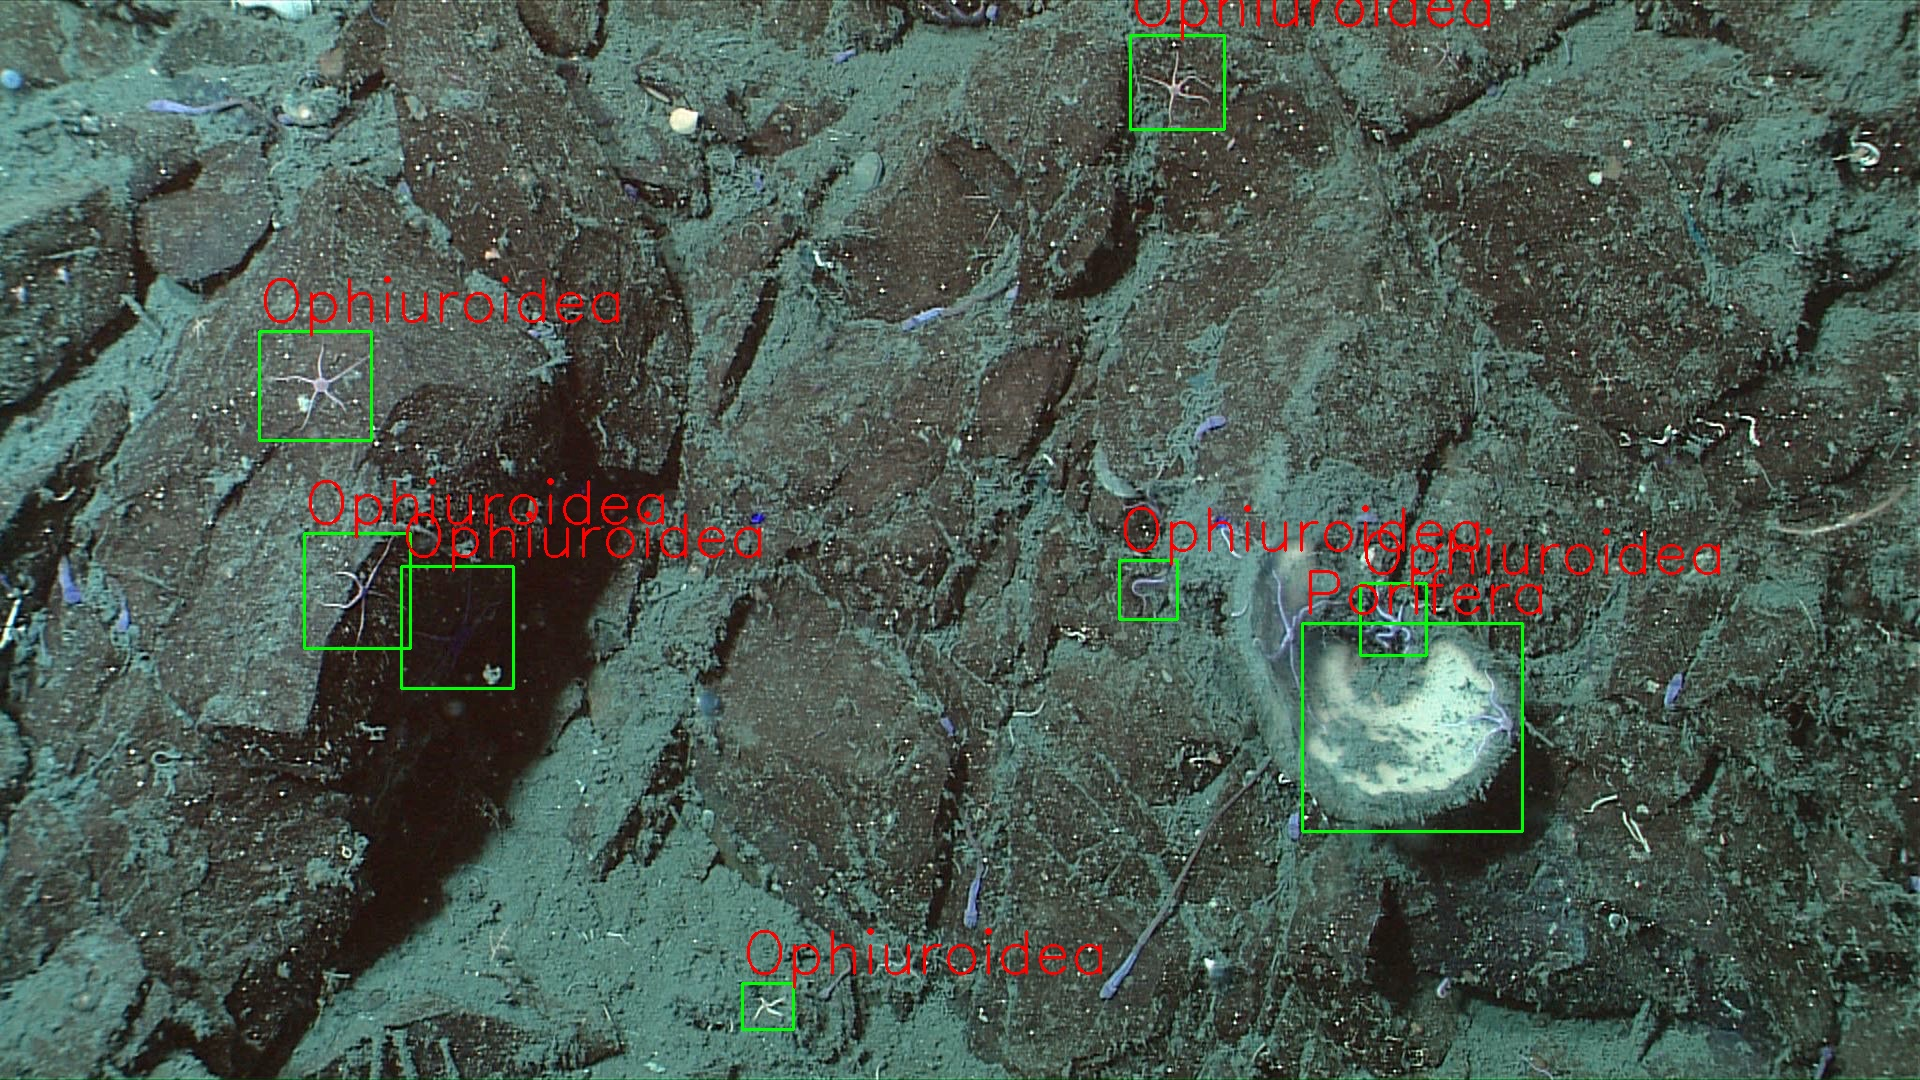

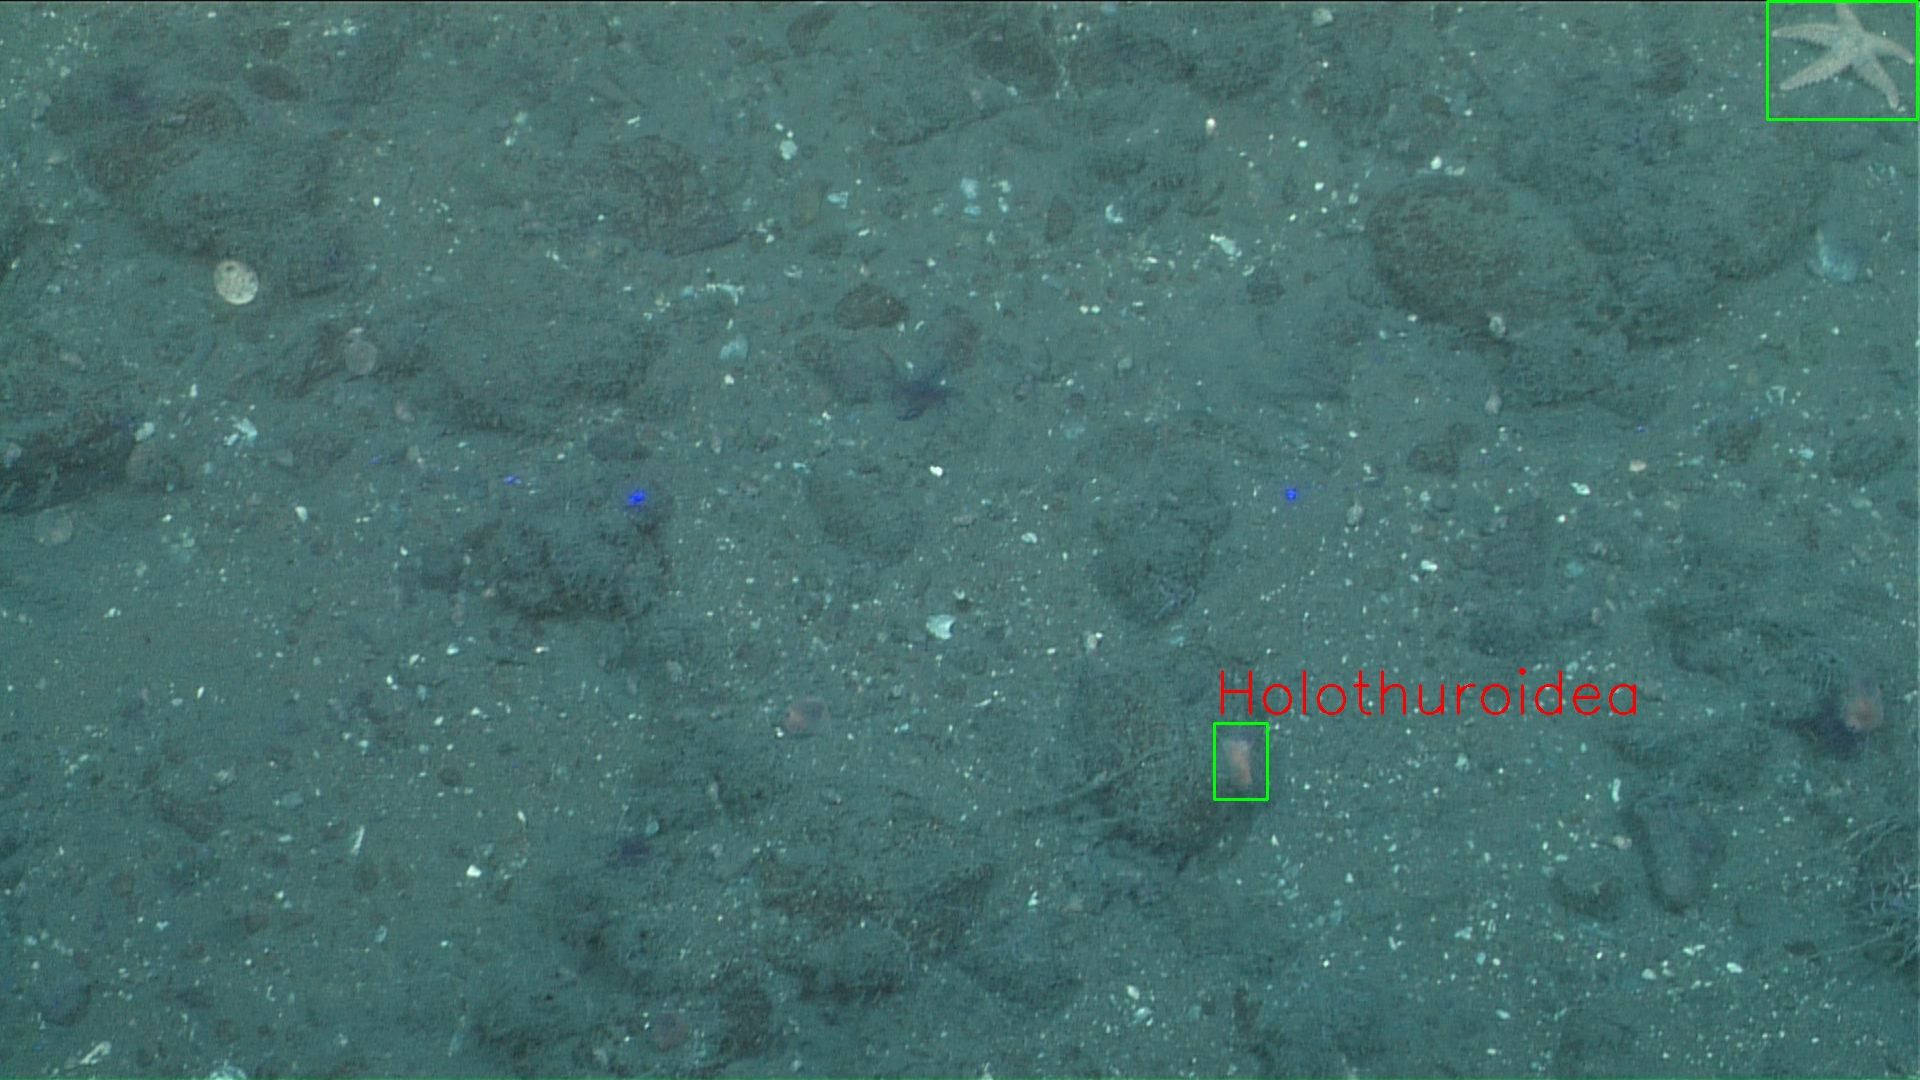

In [15]:
## Sample images for training here
import os
import numpy as np

number_to_choose = 2

image_dir = os.path.join(data_directory, 'images', train_dir)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, png = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parse_txt(os.path.join(data_directory, 'labels', train_dir, f"{uid}.txt"), image.shape)
    
    draw_boxes(image, bboxes)

## Train a YOLOv8 Model

In [16]:
!pip install ultralytics -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')

# Train the model
# results = model.train(data=f"{data_directory}/data.yaml", epochs=1)

# Pretrained
model = YOLO('/home/kyle/Documents/ml_projects/ultralytics/runs/detect/train/weights/best.pt')

/home/kyle/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/kyle/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (

0: 512x736 3 Asteroideas, 2 Ophiuroideas, 2.1ms
Speed: 2.7ms preprocess, 2.1ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 736)
Results saved to /home/kyle/Documents/ml_projects/ultralytics/runs/detect/predict4


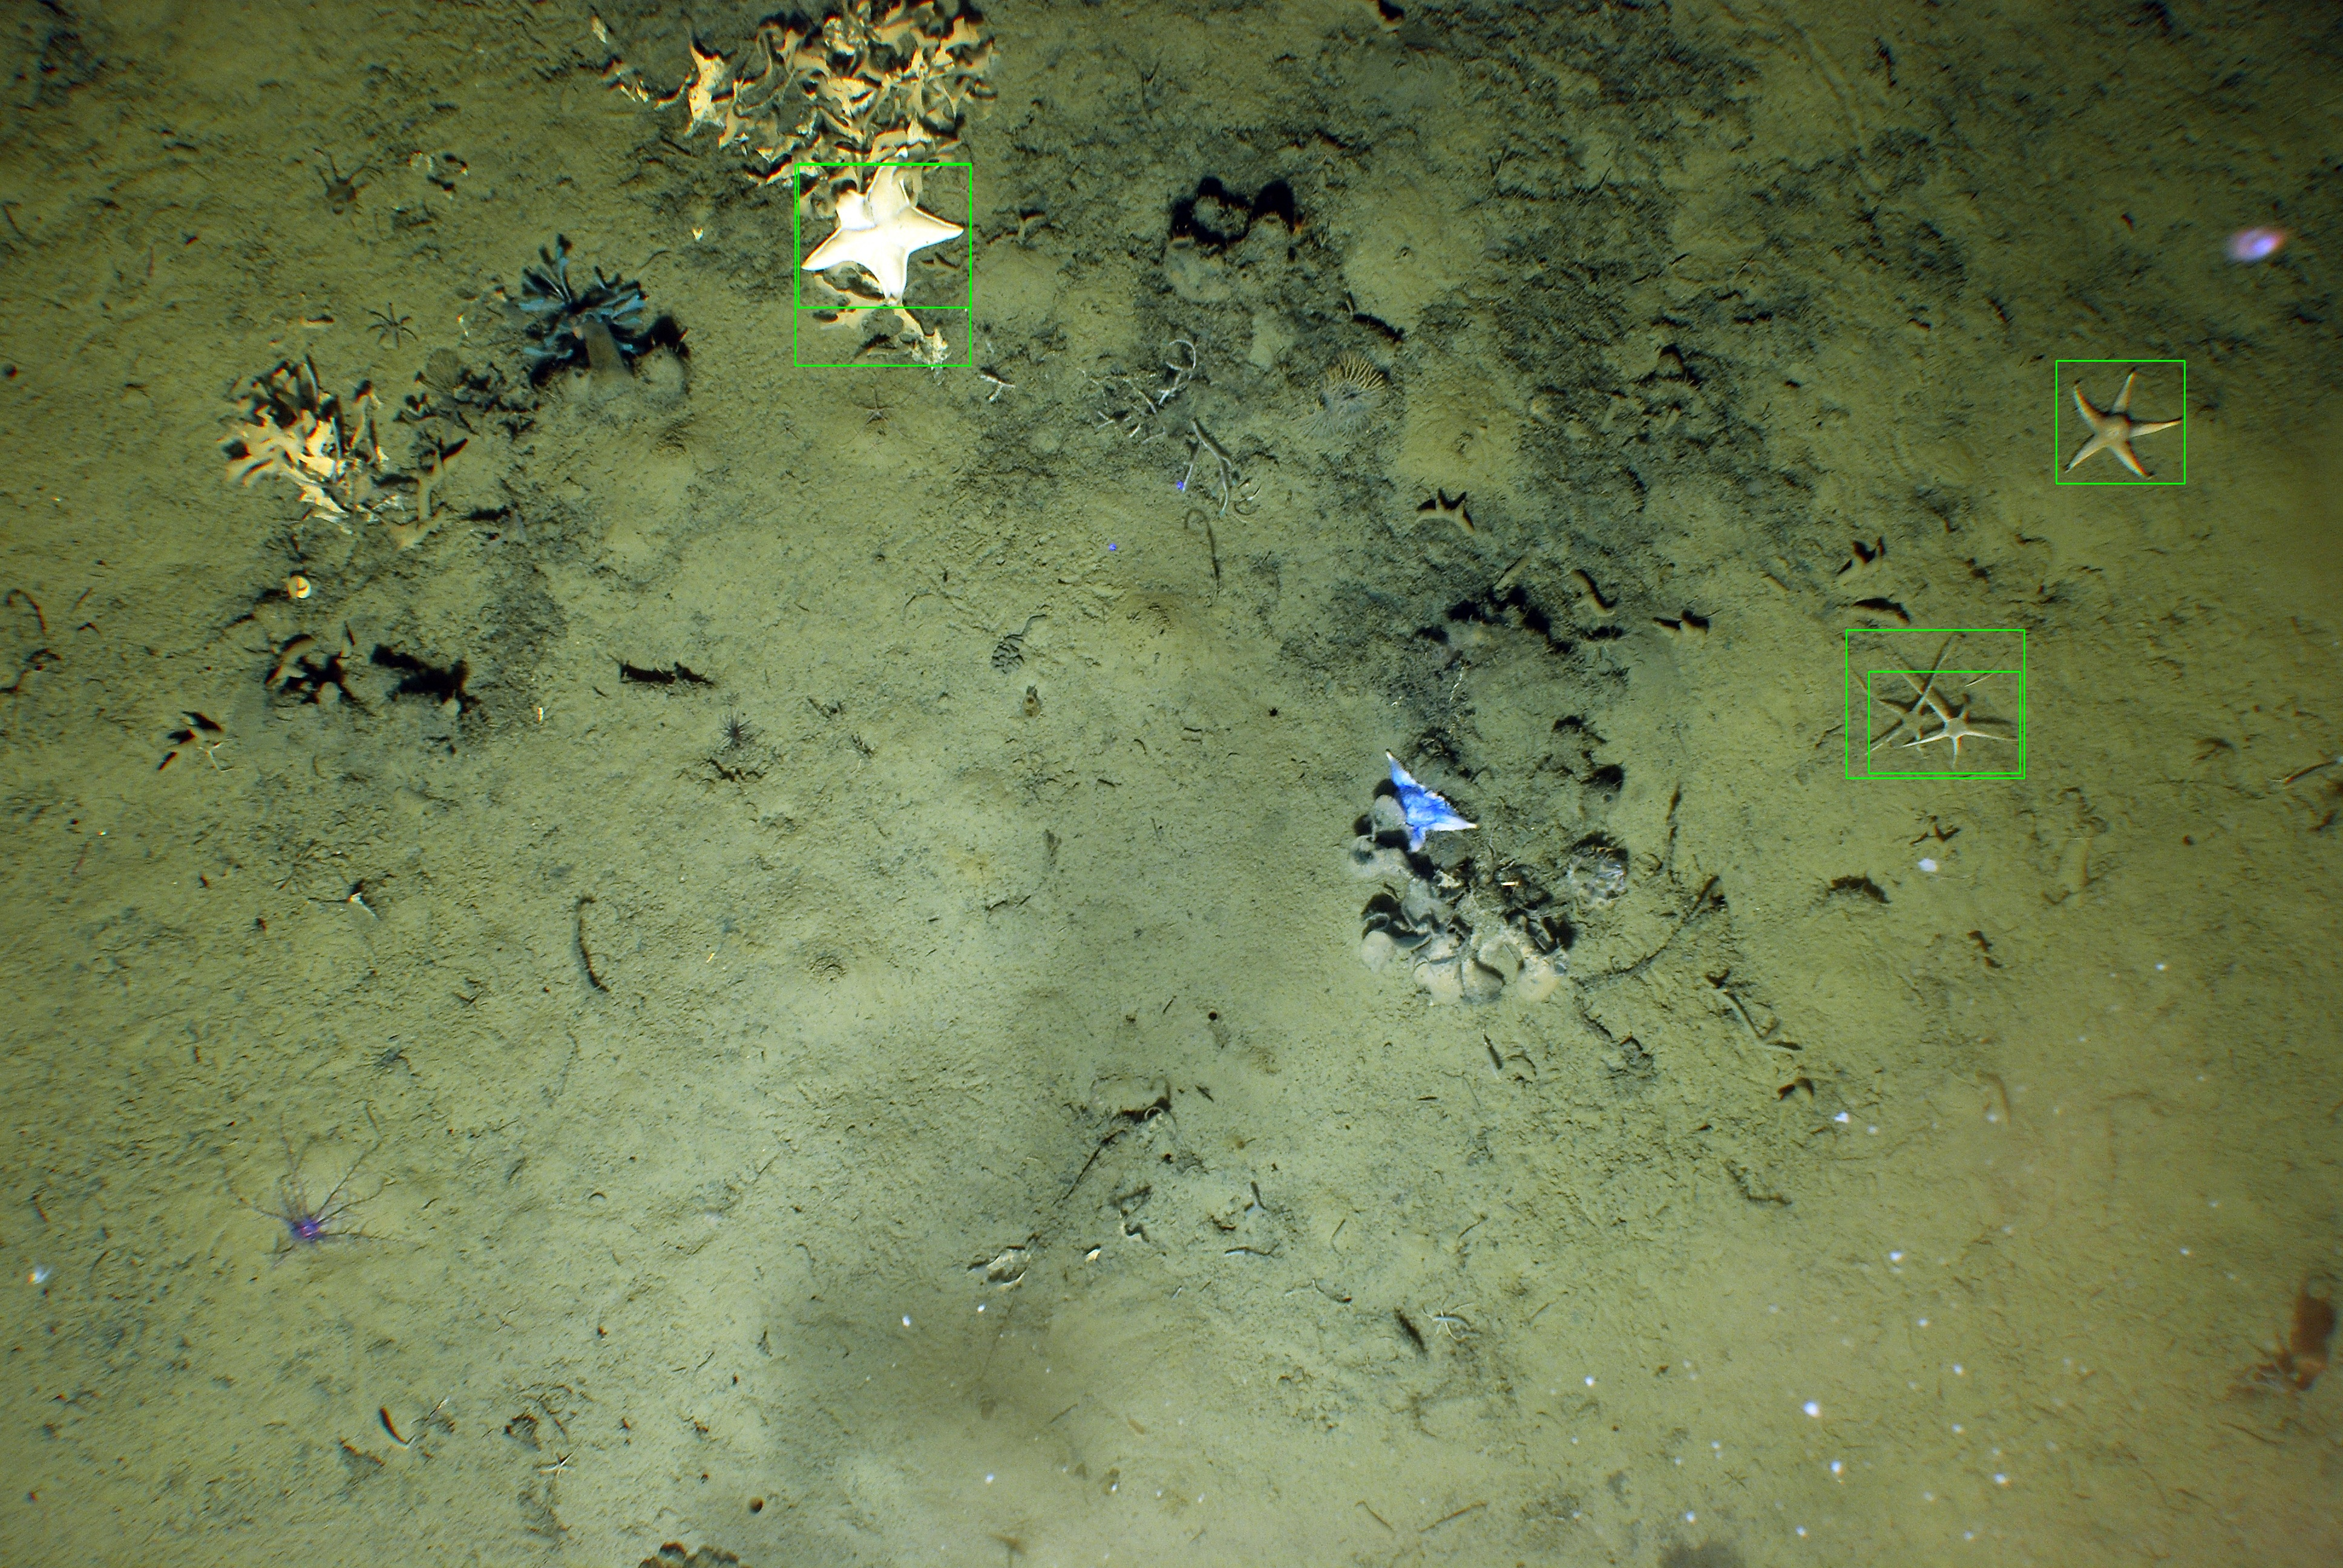

In [18]:
import cv2
from ultralytics.engine.results import Boxes
from IPython.display import display, Image

image = cv2.imread('DSC_0272.jpg')
prediction = model(image, imgsz=[512, 736], conf=0.1, save=True)

for bbox in prediction[0].boxes:
    x1, y1, x2, y2 = bbox.xyxy.cpu()[0].numpy()
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Convert the image to RGB format for displaying in the notebook
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes in the notebook
display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

# Train an RCNN model

In [19]:
!pip install torch torchvision pillow -q

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cpu")

model = fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


/home/kyle/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kyle/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import RPNHead

num_classes = len(concepts_to_include)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [68]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import xml.etree.ElementTree as ET


class CustomVOCDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join(data_directory, 'images')
        self.label_dir = os.path.join(data_directory, 'labels')

        self.image_files = [filename for filename in os.listdir(self.image_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name)[:,:,:3]
        image = np.transpose(image, (2, 0, 1))
        
        annotation_file = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.xml')

        tree = ET.parse(annotation_file)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.iter("object"):
            label = obj.find("name").text
            labels.append(label)
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor([int(concepts_to_include.index(label)) for label in labels], dtype=torch.int64)


        return torch.from_numpy(image / 255.0), target

In [69]:
from torch.utils.data import DataLoader

dataset = CustomVOCDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [70]:
for im, tar in data_loader:
    print(tar['boxes'])

tensor([[[198., 149., 239., 181.]]])
tensor([[[ 990.,  441., 1095.,  538.],
         [1640.,  567., 1800.,  705.],
         [1516.,  196., 1623.,  280.],
         [1043.,  910., 1224., 1072.],
         [ 803.,  827.,  936.,  933.],
         [ 408.,  181.,  536.,  268.],
         [ 588.,  706.,  782.,  873.]]])
tensor([[[1860.,  726., 1919.,  795.],
         [1405.,   40., 1458.,   78.]]])
tensor([[[671., 440., 700., 469.]]])
tensor([[[ 627.,  500.,  682.,  559.],
         [1221.,  673., 1258.,  713.],
         [1253.,   70., 1296.,  110.],
         [1251.,  652., 1289.,  685.],
         [ 269.,   88.,  368.,  180.],
         [ 709.,    3.,  796.,   76.],
         [1313.,  755., 1351.,  787.],
         [ 934.,   59.,  976.,   95.],
         [ 238.,  207.,  281.,  241.],
         [   0.,   18.,   22.,   76.]]])
tensor([[[1037.,  815., 1349., 1059.],
         [ 277.,   34.,  438.,  159.]]])
tensor([[[1150., 1000., 1187., 1034.]]])
tensor([[[1862.,  712., 1920.,  804.]]])
tensor([[[129., 2

KeyboardInterrupt: 

In [76]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)

model.train()

num_epochs = 1
for epoch in range(num_epochs):
    for images, targets in data_loader:
        images = list(image.to(device=device, dtype=torch.float) for image in images)
        targets = [{k: v[0].to(device) for k, v in targets.items()}]
        
        loss_dict = model(images, targets)
        sum_loss = sum(loss for loss in loss_dict.values())
    
        sum_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {sum_loss / len(images)}")

boxes
tensor([[412., 240., 463., 277.]])
labels
tensor([2])
boxes
tensor([[ 746.,  434.,  784.,  469.],
        [1211., 1036., 1241., 1080.],
        [ 929.,  856.,  976.,  914.]])
labels
tensor([4, 4, 4])
boxes
tensor([[1613., 1011., 1654., 1050.],
        [1256.,  685., 1296.,  725.],
        [1888.,  626., 1920.,  684.],
        [ 987.,  362., 1020.,  393.]])
labels
tensor([7, 7, 7, 7])


KeyboardInterrupt: 

In [ ]:
model.eval()

image = cv2.imread('DSC_0272.jpg')[:,:,:3]
image = np.transpose(image, (2, 0, 1))

input_image = torch.from_numpy(image / 255.0).to(dtype=torch.float32)
input_image = input_image.unsqueeze_(0)

with torch.no_grad():
    model.eval()
    output = model(input_image)

In [ ]:
output